# Objective Optimizations

This notebook demonstrates a use case for Amazon Personalize Objective Optimization. Oftentimes there are other factors that influence the recommendations, and the objective optimization can be used to provide additional data to drive the model.

This example assumes we are providing recommendations for a video on demand (VOD) streaming subscription service. The service allows users unlimited access to the video catalog, however the titles available in their catalog have different licensing terms depending on the arrangement with the content owner. By providing recommendations that provide weighting to the content with lower licensing costs, the streaming service can lower licensing costs while still keeping customers happy.

Again, the data is coming from the [MovieLens](https://movielens.org/) project, you can learn more about the data and potential uses by doing a web search during any of the waiting periods in the cells below. You will supplement the MovieLens data with an additional royalty field and generate the data that will provide the royalty costs to the dataset. 

## How to Use the Notebook

Code is broken up into cells like the one below. There's a triangular `Run` button at the top of this page you can click to execute each cell and move onto the next, or you can press `Shift` + `Enter` while in the cell to execute it and move onto the next one.

As a cell is executing you'll notice a line to the side showcase an `*` while the cell is running or it will update to a number to indicate the last cell that completed executing after it has finished exectuting all the code within a cell.


Simply follow the instructions below and execute the cells to get started with Amazon Personalize Objective Optimization.

## Imports 

Python ships with a broad collection of libraries and we need to import those as well as the ones installed to help us like [boto3](https://aws.amazon.com/sdk-for-python/) (AWS SDK for python) and [Pandas](https://pandas.pydata.org/)/[Numpy](https://numpy.org/) which are core data science tools.

In [1]:
# Imports
import boto3
import json
import numpy as np
import pandas as pd
import time
from botocore.exceptions import ClientError

!conda install -y -c conda-forge unzip

pd.options.mode.chained_assignment = None

Solving environment: | ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



Next you will want to validate that your environment can communicate successfully with Amazon Personalize, the lines below do just that.

In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

## Configure the data

Data is imported into Amazon Personalize through Amazon S3, below we will specify a filenames that you use to write the files locally before uploading them to S3.


In [3]:
filename = "movie-lens-100k.csv"
items_filename = "movie-lens-items.csv"

### Download, Prepare, and Upload Training Data

At present you do not have the MovieLens data loaded locally yet for examination, execute the lines below to download the latest copy and to examine it quickly.

#### Download and Explore the Dataset

In [4]:
!wget -N http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip
data = pd.read_csv('./ml-100k/u.data', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
pd.set_option('display.max_rows', 5)
data

--2021-08-03 20:47:43--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ml-100k.zip’ not modified on server. Omitting download.

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflat

,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,196,242,3,881250949
1,186,302,3,891717742
...,...,...,...,...
99998,13,225,2,882399156
99999,12,203,3,879959583


#### Prepare and Upload Data

The code below loads the movie information from the MovieLens download. It provides information on the title, release date, IMDB link, and a list of columns to capture the genres that apply to the title.

There isn't a royalty field since the workshop is generating a ficticious royalty, and will do that in the next step.








In [5]:
items = pd.read_csv('./ml-100k/u.item', sep='|',encoding='latin-1', names=['ITEM_ID', 'TITLE', 'RELEASE_DATE', 'VIDEO_RELEASE_DATE', 'IMDB_URL', 'MISC', 'ACTION_GENRE', 'ADVENTURE_GENRE', 'ANIMATION_GENRE', 'CHILDRENS_GENRE','COMEDY_GENRE', 'CRIME_GENRE', 'DOCUMENTARY_GENRE','DRAMA_GENRE','FANTASY_GENRE', 'FILMNOIR_GENRE','HORROR_GENRE', 'MUSICAL_GENRE','MYSTERY_GENRE', 'ROMANCE_GENRE', 'SCIFI_GENRE', 'THRILLER_GENRE', 'WAR_GENRE', 'WESTERN_GENRE'     ])
items

,ITEM_ID,TITLE,RELEASE_DATE,VIDEO_RELEASE_DATE,IMDB_URL,MISC,ACTION_GENRE,ADVENTURE_GENRE,ANIMATION_GENRE,CHILDRENS_GENRE,...,FANTASY_GENRE,FILMNOIR_GENRE,HORROR_GENRE,MUSICAL_GENRE,MYSTERY_GENRE,ROMANCE_GENRE,SCIFI_GENRE,THRILLER_GENRE,WAR_GENRE,WESTERN_GENRE
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Add the Royalty Data and Genres
We are assigning a value to the ROYALTY field with a even distribution of the values 0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.10. This places most of the movies with a relatively low or zero royalty and a small number of movies with a higher royalty. 

Note on the bar chart below the even distribution of titles with each royalty value.

The MovieLens GENRE field result above is categorical with each column indicating whether the title belongs to the genre, but the items loaded into the personalization can accept arrays. Some pandas code to pull together the genres into a pipe delimited column listing all the genres.



,ITEM_ID,TITLE,ROYALTY,GENRE
0,1,Toy Story (1995),0.005,ANIMATION|CHILDRENS|COMEDY
1,2,GoldenEye (1995),0.010,ACTION|ADVENTURE|THRILLER
2,3,Four Rooms (1995),0.015,THRILLER
3,4,Get Shorty (1995),0.020,ACTION|COMEDY|DRAMA
4,5,Copycat (1995),0.025,CRIME|DRAMA|THRILLER
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,0.050,DRAMA
6,7,Twelve Monkeys (1995),0.100,DRAMA|SCIFI
7,8,Babe (1995),0.000,CHILDRENS|COMEDY|DRAMA
8,9,Dead Man Walking (1995),0.005,DRAMA
9,10,Richard III (1995),0.010,DRAMA|WAR


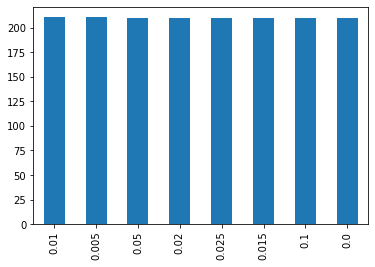

In [6]:
pd.set_option('display.max_rows', 10)

royaltyvalues = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.10]
items.loc[:,'ROYALTY'] = items['ITEM_ID'].map(lambda x: royaltyvalues[x%8])

items.loc[:,'GENRE']='' 

for col_name in items.columns:
    if col_name.endswith('_GENRE'):
        items.loc[items[col_name]==1,'GENRE']= items['GENRE']+'|'+ col_name[:-6]

items = items[['ITEM_ID', 'TITLE','ROYALTY', 'GENRE']]
items.loc[:,'GENRE'] = items['GENRE'].str[1:]


items.loc[:,'ROYALTY'].value_counts().plot.bar()
items.head(10)


#### Adjust the royalty value to a negative number.

Objective Optimization will optimize to the highest values of a field. In this case, we want to balance the relevance of the movie against the royalty expenses that will be incurred by the streaming service.

To boost the movies with the lowest royalities, the movies with the lowest royalties need the highest numerical values. In this case, we will convert royalties to a negative number. This is done by multiplying -1 by the absolute value of the royalty fee.

Note: The absolute value is used so this cell can be run twice with the same results, which is helpful in a workshop environment.

In [7]:
items.loc[:,'ROYALTY'] = -1 * abs(items['ROYALTY'])
items

,ITEM_ID,TITLE,ROYALTY,GENRE
0,1,Toy Story (1995),-0.005,ANIMATION|CHILDRENS|COMEDY
1,2,GoldenEye (1995),-0.010,ACTION|ADVENTURE|THRILLER
2,3,Four Rooms (1995),-0.015,THRILLER
3,4,Get Shorty (1995),-0.020,ACTION|COMEDY|DRAMA
4,5,Copycat (1995),-0.025,CRIME|DRAMA|THRILLER
...,...,...,...,...
1677,1678,Mat' i syn (1997),-0.050,DRAMA
1678,1679,B. Monkey (1998),-0.100,ROMANCE|THRILLER
1679,1680,Sliding Doors (1998),-0.000,DRAMA|ROMANCE
1680,1681,You So Crazy (1994),-0.005,COMEDY


## Configure an S3 bucket and an IAM  role <a class="anchor" id="bucket_role"></a>
So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to instance running this Jupyter notebook. However, Amazon Personalize will need an S3 bucket to act as the source of your data, as well as IAM roles for accessing that bucket. Let's set all of that up.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

In [8]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    notebook_data = json.load(notebook_info)
    resource_arn = notebook_data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalize-objective-optimization-` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell.

In [9]:
s3 = boto3.client('s3')
suffix = str(np.random.uniform())[4:9]
bucket_name = "personalize-objective-optimization-"+   suffix        # replace with the name of your S3 bucket
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

personalize-objective-optimization-80880


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV file of our item data. 

In [10]:
items = items[['ITEM_ID', 'TITLE', 'GENRE', 'ROYALTY']]
items_dataset = items[['ITEM_ID','ROYALTY', 'GENRE']]

items_dataset.to_csv(items_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(items_filename).upload_file(items_filename)

### Set the S3 bucket policy
Amazon Personalize needs to be able to read the contents of your S3 bucket. So add a bucket policy which allows that.

In [11]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': 'A70V3STAGXY2K5E6',
  'HostId': 'h+mtvtFKmbsE6tkNyynkUegeEFL/dvarXimc2AvDtgeJs9QNQ9G5VPqHSz1B/+YPi+C4wfCqT9c=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'h+mtvtFKmbsE6tkNyynkUegeEFL/dvarXimc2AvDtgeJs9QNQ9G5VPqHSz1B/+YPi+C4wfCqT9c=',
   'x-amz-request-id': 'A70V3STAGXY2K5E6',
   'date': 'Tue, 03 Aug 2021 20:47:45 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

#### Create the Movie Title Item Schema
We will need two schemas, one for the movie titles, which will be a type Items, and a second which will define the structure of the Interactions.

In [12]:
schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "ROYALTY",
            "type": "float"
        },        {
            "name": "GENRE",
            "type": [
                "null",
                "string"
              ],
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_item_schema_response = personalize.create_schema(
    name = "personalize-objective-optmization-item-schema"+suffix,
    schema = json.dumps(schema)
)

item_schema_arn = create_item_schema_response['schemaArn']
print(json.dumps(create_item_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:383086473915:schema/personalize-objective-optmization-item-schema80880",
  "ResponseMetadata": {
    "RequestId": "b2378b35-adc9-44be-b49e-d7c8a8a68e42",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 03 Aug 2021 20:47:44 GMT",
      "x-amzn-requestid": "b2378b35-adc9-44be-b49e-d7c8a8a68e42",
      "content-length": "116",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


From this point, we will follow the same process from the [first campaign](https://github.com/aws-samples/amazon-personalize-samples/blob/master/getting_started/notebooks/1.Building_Your_First_Campaign.ipynb), loading the interactions. We only want to include interactions with at least a rating of three, and we don't want to recommend movies viewers will not like.

In [13]:
data = data[data['RATING'] > 3]                # Keep only movies rated higher than 3 out of 5.
data = data[['USER_ID', 'ITEM_ID', 'TIMESTAMP']] # select columns that match the columns in the schema below
data.to_csv(filename, index=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(filename).upload_file(filename)

### Create Interaction Schema

A core component of how Personalize understands your data comes from the Schema that is defined below. This configuration tells the service how to digest the data provided via your CSV file. Note the columns and types align to what was in the file you created above.

In [14]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "personalize-objective-optmization-schema"+suffix,
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:383086473915:schema/personalize-objective-optmization-schema80880",
  "ResponseMetadata": {
    "RequestId": "2cf37951-5ed1-4d38-a11e-f03d63fdf7af",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 03 Aug 2021 20:47:45 GMT",
      "x-amzn-requestid": "2cf37951-5ed1-4d38-a11e-f03d63fdf7af",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create and Wait for Dataset Group

The largest grouping in Personalize is a Dataset Group, this will isolate your data, event trackers, solutions, and campaigns. Grouping things together that share a common collection of data. Feel free to alter the name below if you'd like.

#### Create Dataset Group

In [15]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "personalize-objective-optmization-demo-"+suffix
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:383086473915:dataset-group/personalize-objective-optmization-demo-80880",
  "ResponseMetadata": {
    "RequestId": "3f7b18e2-cdb1-4196-ab6d-61b53aca6553",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 03 Aug 2021 20:47:45 GMT",
      "x-amzn-requestid": "3f7b18e2-cdb1-4196-ab6d-61b53aca6553",
      "content-length": "123",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Wait for Dataset Group to Have ACTIVE Status

Before we can use the Dataset Group in any items below it must be active, execute the cell below and wait for it to show active.

In [ ]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

#### Create Dataset

After the group, the next thing to create is the actual datasets, in this example we will create 1 for the interactions data and another for the items data. Execute the cells below to create it.

In [ ]:
def create_dataset(dataset_type, schema_arn, name):
    create_dataset_response = personalize.create_dataset(
        name = name,
        datasetType = dataset_type,
        datasetGroupArn = dataset_group_arn,
        schemaArn = schema_arn
    )
    dataset_arn = create_dataset_response['datasetArn']

    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        describe_dataset_response = personalize.describe_dataset(
            datasetArn = dataset_arn
        )
        status = describe_dataset_response["dataset"]["status"]
        print("Dataset: {} {}".format(name, status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(10)
    return dataset_arn


In [ ]:
interaction_dataset_arn = create_dataset("INTERACTIONS", schema_arn, 'personalize-objective-optmization-interactions-'+suffix)


print('interaction_dataset_arn: ' + interaction_dataset_arn)


In [ ]:
item_dataset_arn = create_dataset("ITEMS", item_schema_arn, 'personalize-objective-optmization-items-'+suffix)
print('item_dataset_arn: ' + item_dataset_arn)

#### Create Personalize Role

Also Amazon Personalize needs the ability to assume Roles in AWS in order to have the permissions to execute certain tasks, the lines below grant that.

In [ ]:
iam = boto3.client("iam")

role_name = "PersonalizeRoleDemo"+suffix
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

## Import the data

Earlier you created the DatasetGroup and Dataset to house your information, now you will execute an import job that will load the data from S3 into Amazon Personalize for usage building your model. We will load multiple imports, so the function below will be called to start the import job, then monitor the import job for completion.

#### Create Dataset Import Job

In [ ]:
def create_dataset_import_job(dataset_arn, dataLocation, name):
    create_dataset_import_job_response = personalize.create_dataset_import_job(
        jobName = name,
        datasetArn = dataset_arn,
        dataSource = {
            "dataLocation": dataLocation
        },
        roleArn = role_arn
    )

    dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
    
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = dataset_import_job_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        print("DatasetImportJob: {} {}".format(name, status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(60)
    return dataset_import_job_arn

#### Load the interactions
The import job below will load the interaction dataset.

In [ ]:
dataset_import_job_arn = create_dataset_import_job(interaction_dataset_arn, "s3://{}/{}".format(bucket_name, filename), "personalize-objective-optimization-interaction-"+suffix)
print('dataset_import_job_arn: ' + dataset_import_job_arn)

#### Load the movie titles into the item dataset

It can take a while before the import job completes, please wait until you see that it is active below.

In [ ]:
item_dataset_import_job_arn = create_dataset_import_job(item_dataset_arn, "s3://{}/{}".format(bucket_name, items_filename), "personalize-objective-optimization-item-"+suffix)
print('item_dataset_import_job_arn: ' + item_dataset_import_job_arn)

## Create the Solution and Version

In Amazon Personalize a trained model is called a Solution, each Solution can have many specific versions that relate to a given volume of data when the model was trained.

To begin we will list all the recipies that are supported, a recipie is an algorithm that has not been trained on your data yet. After listing you'll select one and use that to build your model.

### Select Recipe

#### User Personalization
The [User-Personalization](https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-new-item-USER_PERSONALIZATION.html) (aws-user-personalization) recipe is optimized for all USER_PERSONALIZATION recommendation scenarios. When recommending items, it uses automatic item exploration.

With automatic exploration, Amazon Personalize automatically tests different item recommendations, learns from how users interact with these recommended items, and boosts recommendations for items that drive better engagement and conversion. This improves item discovery and engagement when you have a fast-changing catalog, or when new items, such as news articles or promotions, are more relevant to users when fresh.

You can balance how much to explore (where items with less interactions data or relevance are recommended more frequently) against how much to exploit (where recommendations are based on what we know or relevance). Amazon Personalize automatically adjusts future recommendations based on implicit user feedback.

First, select the recipe by finding the ARN in the list of recipes above.

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-user-personalization" # aws-user-personalization selected for demo purposes

### Create and Wait for Solution

First you will create the solution with the API, then you will create a version. It will take several minutes to train the model and thus create your version of a solution. Once it gets started and you are seeing the in progress notifications it is a good time to take a break, grab a coffee, etc.

The function accepts the objective sensitibility setting, which can be OFF, LOW, MED, or HIGH. This will adjust the weighting that drives the impact of the objective into the model.

The function creates the solution and the initial solution version for that solution.

#### Create Solution

In [ ]:
def create_solution(name, objectiveSensitivity):
    create_solution_response = personalize.create_solution(
        name = name,
        datasetGroupArn = dataset_group_arn,
        recipeArn = recipe_arn,
        solutionConfig = {
            "optimizationObjective": {
                "itemAttribute": "ROYALTY",
                "objectiveSensitivity":objectiveSensitivity
            }
        }
    )
    
    solution_arn = create_solution_response['solutionArn']
    
    print('solutionArn:' + solution_arn)

    create_solution_version_response = personalize.create_solution_version(
        solutionArn = solution_arn
    )

    solution_version_arn = create_solution_version_response['solutionVersionArn']
    print('solution_version_arn: ' + solution_version_arn)

    return {
        "solution_arn": solution_arn,
        "solution_version_arn": solution_version_arn
    }
    
def waitForSolutionVersion(solution_version_arn):
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        describe_solution_version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = describe_solution_version_response["solutionVersion"]["status"]
        print("SolutionVersion: {} {}".format(solution_version_arn, status))

        if status == "ACTIVE" or status == "CREATE FAILED"  or status == "CREATE STOPPING":
            break

        time.sleep(60)

#### Create the Solution Versions
Create 3 different solutions, one with objective optimization turned off, one with a LOW setting, and one set to HIGH. This will kick off 3 solutions in parallel, and the next step will wait for them to complete.

In [ ]:
high_solution = create_solution('movie-recommendation-low-royalties-'+suffix, 'HIGH')
low_solution = create_solution('movie-recommendation-medium-royalties-'+suffix, 'LOW')
no_objective_optimization_solution = create_solution('movie-recommendation-max-relevance-'+suffix, 'OFF')

#### Wait for Solution Versions to Have ACTIVE Status

This will take approximately 40-50 minutes.

In [ ]:
waitForSolutionVersion(low_solution['solution_version_arn'])
waitForSolutionVersion(no_objective_optimization_solution['solution_version_arn'])
waitForSolutionVersion(high_solution['solution_version_arn'])

#### Get Metrics of Solution Versions

Now that your solution and version exists, you can obtain the metrics for it to judge its performance. These metrics are not particularly good as it is a demo set of data, but with larger more complex datasets you should see improvements.

You can see differences in the quality of the model based on the impact of the objective optimizations.

In [ ]:
def get_solution_metrics(solutions):
    metricdata = { "name": []}
    
    for key in solutions:
        solution = solutions[key]
        
        metricdata["name"].append(key)
        
        get_solution_metrics_response = personalize.get_solution_metrics(
            solutionVersionArn = solution['solution_version_arn']
        )

        for metricname in get_solution_metrics_response['metrics']:
            if not metricname in metricdata:
                metricdata[metricname] = []
                
            metricdata[metricname].append( get_solution_metrics_response['metrics'][metricname])
            
        # print(json.dumps(get_solution_metrics_response, indent=2))
    return pd.DataFrame.from_dict(metricdata);

metrics = get_solution_metrics({
    "no-optimization": no_objective_optimization_solution,
    "low-optimization": low_solution,
    "high-optimization": high_solution,
})

metrics

We recommend reading [the documentation](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html) to understand the metrics, but we have also copied parts of the documentation below for convenience.

You need to understand the following terms regarding evaluation in Personalize:

- *Relevant recommendation* refers to a recommendation that matches a value in the testing data for the particular user.
- *Rank* refers to the position of a recommended item in the list of recommendations. Position 1 (the top of the list) is presumed to be the most relevant to the user.
- *Query* refers to the internal equivalent of a GetRecommendations call.

The metrics produced by Personalize are:

- coverage: The proportion of unique recommended items from all queries out of the total number of unique items in the training data (includes both the Items and Interactions datasets).
- mean_reciprocal_rank_at_25: The [mean of the reciprocal ranks](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) of the first relevant recommendation out of the top 25 recommendations over all queries. This metric is appropriate if you're interested in the single highest ranked recommendation.
- normalized_discounted_cumulative_gain_at_K: Discounted gain assumes that recommendations lower on a list of recommendations are less relevant than higher recommendations. Therefore, each recommendation is discounted (given a lower weight) by a factor dependent on its position. To produce the [cumulative discounted gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain) (DCG) at K, each relevant discounted recommendation in the top K recommendations is summed together. The normalized discounted cumulative gain (NDCG) is the DCG divided by the ideal DCG such that NDCG is between 0 - 1. (The ideal DCG is where the top K recommendations are sorted by relevance.) Amazon Personalize uses a weighting factor of 1/log(1 + position), where the top of the list is position 1. This metric rewards relevant items that appear near the top of the list, because the top of a list usually draws more attention.
- precision_at_K: The number of relevant recommendations out of the top K recommendations divided by K. This metric rewards precise recommendation of the relevant items.

## Create and Wait for the Campaign

Now that you have a working solution version you will need to create a campaign to use it with your applications. A campaign is a hosted solution version; an endpoint which you can query for recommendations. Pricing is set by estimating throughput capacity (requests from users for personalization per second). When deploying a campaign, you set a minimum transactions per second (TPS) value (`minProvisionedTPS`). This service, like many within AWS, will automatically scale based on demand, but if latency is critical, you may want to provision ahead for larger demand. For this demo, the minimum throughput threshold is set to 1. For more information, see the [pricing](https://aws.amazon.com/personalize/pricing/) page.

As mentioned above, the user-personalization recipe used for our solution supports automatic exploration of "cold" items. You can control how much exploration is performed when creating your campaign. The `itemExplorationConfig` data type supports `explorationWeight` and `explorationItemAgeCutOff` parameters. Exploration weight determines how frequently recommendations include items with less interactions data or relevance. The closer the value is to 1.0, the more exploration. At zero, no exploration occurs and recommendations are based on current data (relevance). Exploration item age cut-off determines items to be explored based on time frame since latest interaction. Provide the maximum item age, in days since the latest interaction, to define the scope of item exploration. The larger the value, the more items are considered during exploration. For our campaign below, we'll specify an exploration weight of 0.5.

#### Create Campaign

In [ ]:
def create_campaign(solution, name):
    create_campaign_response = personalize.create_campaign(
        name = "personalize-demo-" + name + '-' + suffix,
        solutionVersionArn = solution['solution_version_arn'],
        minProvisionedTPS = 1,
        campaignConfig = {
            "itemExplorationConfig": {
                "explorationWeight": "0.5"
            }
        }
    )

    campaign_arn = create_campaign_response['campaignArn']
    print('campaign_arn:' + campaign_arn)
    return campaign_arn

def waitForCampaign(solution):
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        describe_campaign_response = personalize.describe_campaign(
            campaignArn = solution['campaign_arn']
        )
        status = describe_campaign_response["campaign"]["status"]
        print("Campaign: {} {}".format(solution['campaign_arn'], status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(60)

#### Create 3 Campaigns
Create a campaign for each of the objective optimizations, but keep all the other settings the same to demonstrate the impact of the objective optimization.

In [ ]:
high_solution['campaign_arn'] = create_campaign(high_solution, 'high')
low_solution['campaign_arn'] = create_campaign(low_solution, 'low')
no_objective_optimization_solution['campaign_arn'] = create_campaign(no_objective_optimization_solution, 'max_relevance')


#### Wait for Campaign to Have ACTIVE Status

This should take about 10 minutes.

In [ ]:
waitForCampaign(high_solution)
waitForCampaign(low_solution)
waitForCampaign(no_objective_optimization_solution)

## Get Sample Recommendations

After the campaign is active you are ready to get recommendations. First we need to select a random user from the collection. Then we will create a few helper functions for getting movie information to show for recommendations instead of just IDs.

In [ ]:
# Getting a random user:
user_id, item_id, _ = data.sample().values[0]
print("USER: {}".format(user_id))

In [ ]:

def get_movie_title(movie_id):
    """
    Takes in an ID, returns a title
    """
    movie_id = int(movie_id)-1
    return items.iloc[movie_id]['TITLE'] + '(' + f'{-1*items.iloc[movie_id]["ROYALTY"]:.2f}'+ ')'

def get_movie_royalty(movie_id):
    """
    Takes in an ID, returns a title
    """
    movie_id = int(movie_id)-1
    return -1*items.iloc[movie_id]["ROYALTY"]

#### Call GetRecommendations

Using the user that you obtained above, the lines below will get recommendations for you and return the list of movies that are recommended.


In [ ]:
def get_recommendations(solution):
    get_recommendations_response = personalize_runtime.get_recommendations(
        campaignArn = solution['campaign_arn'],
        userId = str(user_id),
    )
    # Update DF rendering
    pd.set_option('display.max_rows', 30)

    item_list = get_recommendations_response['itemList']

    recommendation_list = []

    total_royalties = 0.0
    
    for item in item_list:
        title = get_movie_title(item['itemId'])
        total_royalties = total_royalties + get_movie_royalty(item['itemId'])
        recommendation_list.append(title)
        
    recommendation_list.append('TOTAL ROYALTIES: '+ f'{total_royalties:.2f}')
    return recommendation_list

#### Compare Recommendations
Create a set of recommendations for the same user to compare the impact of the objective optimization.

Notice the impact of the royalty value shown in parantheses after the title and year. Highly rated, high royalty movies with objective optimization off tend to show up lower in the list, if at all, when the objective optmization is on. 

Also note the total royalties for all the titles in each set of recommendations.

In [ ]:
recommendations_df = pd.DataFrame(get_recommendations(no_objective_optimization_solution), columns = ['ObjectiveOff'])
recommendations_df['LowObjective'] = get_recommendations(low_solution)
recommendations_df['HighObjective'] = get_recommendations(high_solution)
recommendations_df

## Review

The notebook walked through an example where the movie recommendation engine took into account the royalties needed to pay for a given title. By including this weighting into the recommendation algorithm, the streaming service can provide good recommendations for a user, but also minimize the royalties needed to pay out to content creators.

Notice in the chart above, with Objective optimization off, the royalty fee in paratheses is fairly evenly distributed, as one would expect since it isn't taken into account. However, in the LowObjective column, the values are lower and the sum of the royalties is lowest for the highest objective optimization setting.

## Cleanup

Clean up the resources

In [ ]:
def delete_campaign(campaign_arn):
    delete_campaign_result = personalize.delete_campaign(campaignArn=campaign_arn )
    

def wait_for_delete_campaign(campaign_arn):
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        try:
            describe_campaign_response = personalize.describe_campaign(
                campaignArn = campaign_arn
            )
            status = describe_campaign_response["campaign"]["status"]
            print("campaign: {}".format(status))

        except ClientError as e:
            print(e)
            break

        time.sleep(10)
    print('campaign ' + campaign_arn + ' deleted')
    
def delete_solution(solution_arn):
    delete_solution_result = personalize.delete_solution(solutionArn=solution_arn )
    
    max_time = time.time() + 3*60*60 # 3 hours

def wait_for_delete_solution(solution_arn):
    while time.time() < max_time:
        
        try:
            describe_solution_response = personalize.describe_solution(
                solutionArn = solution_arn
            )
            status = describe_solution_response["solution"]["status"]
            print("Solution: {}".format(status))

        except ClientError:
            break
        time.sleep(10)
    print('Solution ' + solution_arn + ' deleted')
    
def delete_dataset(dataset_arn):
    delete_dataset_result = personalize.delete_dataset(datasetArn=dataset_arn )
    
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        try:
            describe_dataset_response = personalize.describe_dataset(
                datasetArn = dataset_arn
            )
            status = describe_dataset_response["dataset"]["status"]
            print("dataset: {}".format(status))

        except ClientError:
            break
        time.sleep(10)
    print('dataset ' + dataset_arn + ' deleted')
    
def delete_schema(schema_arn):
    delete_schema_result = personalize.delete_schema(schemaArn=schema_arn )
    

    print('schema ' + schema_arn + ' deleted')
    
def delete_dataset_group(dataset_group_arn):
    delete_dataset_group_result = personalize.delete_dataset_group(datasetGroupArn=dataset_group_arn )
    
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        try:
            describe_dataset_group_response = personalize.describe_dataset_group(
                datasetGroupArn = dataset_group_arn
            )
            status = describe_dataset_group_response["datasetGroup"]["status"]
            print("dataset_group: {}".format(status))

        except ClientError:
            break
        time.sleep(10)
    print('dataset_group ' + dataset_group_arn + ' deleted')
    
def delete_all(solutions):
    for solution in solutions:
        delete_campaign(solution['campaign_arn'])
        
    for solution in solutions:
        wait_for_delete_campaign(solution['campaign_arn'])
    for solution in solutions:
        delete_solution(solution['solution_arn'])
    for solution in solutions:
        wait_for_delete_solution(solution['solution_arn'])


    

In [ ]:
delete_all([no_objective_optimization_solution, low_solution, high_solution] )

In [ ]:
delete_dataset(item_dataset_arn)
delete_dataset(interaction_dataset_arn)

In [ ]:
delete_schema(item_schema_arn)
delete_schema(schema_arn)

In [ ]:
delete_dataset_group(dataset_group_arn)

In [ ]:
iam = boto3.client("iam")

iam.detach_role_policy(RoleName=role_name, PolicyArn='arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess')
iam.detach_role_policy(RoleName=role_name, PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess')
time.sleep(10) # propogation time

iam.delete_role(RoleName=role_name)

In [ ]:
! aws s3 rm --recursive s3://$bucket_name

In [ ]:
s3.delete_bucket(Bucket=bucket_name)